In [0]:
# To install cupy

!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3798      0 --:--:-- --:--:-- --:--:--  3788
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [0]:
import cupy as cp
import numpy as np
import random
import time 
import matplotlib.pyplot as plt
import matplotlib
from __future__ import print_function

In [0]:
# Some hyper parameters
GAP_SCORE = -8

MATCH_SCORE_TWO_SEQ = 60

#Clean with MATCH_SCORE_TWO_SEQ = 30 and GAP_SCORE = -8

In [0]:

import numpy as np
from sympy import binomial
import os
from __future__ import print_function

def arrayPositionInMatrix(len_sequence, number_cells_computed):
    """
    
    Creates a 1D arrays which indicate for each time step the position 
    of the cells to compute in a Needleman and Wunch flattened matrix. 
    Works only for the alignment of 2 sequences with the same size.
    
    Parameters
    ----------
    len_sequence: int
        The size of the sequences which are aligned.
      
    number_cells_computed: 1D array
        Array which indicate the cumulative total number of cells computed 
        at each time step.
    
    Returns
    -------
    position_in_nw_flatten_matrix: 1D array
        Array which indicate the position of the cells to compute in a Needleman
        and Wunch flattened matrix.
    """
    
    number_steps = 2 * len_sequence - 1  # We can know the number of time steps to entirely compute the NW matrix with the theorie
    shape_matrix = ((len_sequence + 1, len_sequence + 1)) # The "+ 1" to not be bothered with the boundaries

    position_x = [0] # position x of the elements which are computed in a 3D matrix
    position_y = [0] # position y of the elements which are computed in a 3D matrix

    position_in_nw_flatten_matrix = np.empty(shape=((len_sequence)**2, ), dtype=np.int32)
    # Needleman and Wunch matrix flattened 

    for time in range(1, number_steps + 1):
        print("\r{} / {}".format(time, number_steps), end='')
        position_cells_to_compute = np.vstack((position_x, position_y))


         
        interval1 = number_cells_computed[time-1]
        interval2 = number_cells_computed[time]

        position_in_nw_flatten_matrix[interval1:interval2] = np.ravel_multi_index(position_cells_to_compute + 1, shape_matrix) # The "+ 1" to not be bothered with the boundaries


        ## We update the position of the cells to compute for the next time step
        if (time < len_sequence):
            position_x.append(time)
            position_y.insert(0, time)

        else:
            position_x.pop(0)
            position_y.pop()
            

    return position_in_nw_flatten_matrix
  
  
def CalculProcessingUnitRequired(dimension, time_step, len_sequence):
  
    """
    
    Calculate for a time step the number of cells which can be computed in
    parallele in a Needleman and Wunch matrix.
    
    
    Parameters
    ----------
    dimension: int
        The dimension of the Needleman and Wunch matrix (it correspond to the 
        number of sequences that needs to be aligned).
      
    time_step: int
        Time step 
        
    len_sequence: int
        The size of the sequences which are aligned.
    
    Returns
    -------
    number_cells: int
        Number of cells which can be computed in parallele.
  
  
    """
    
    number_cells = 0
    coefficient_to_add = time_step // len_sequence
    for q in range(coefficient_to_add + 1):
        coefficient = int((-1)**(q) * binomial(dimension + time_step - q*len_sequence - 2, time_step - q*len_sequence - 1) * binomial(dimension, q))
        number_cells += coefficient
    return number_cells


def getNumberProcessingUnitRequired(len_sequence, dimension): # Calcule le nombre de processing unit entre time = 0 et time = (NM - N-1) 
  
    """
    
    Create an array where each elements of index i indicate the number of cells 
    which can be computed in parallele in a Needleman and Wunch matrix at the 
    time step i.
    
    Parameters
    ----------
    len_sequence: int
        The size of the sequences which are aligned.
    
    dimension: int
        The dimension of the Needleman and Wunch matrix (it correspond to the 
        number of sequences that needs to be aligned).
        
    Returns
    -------
    nb_cells_by_time_step: 1D array
        Array where each element of index i indicate the number of cells that 
        you can compute in a Needleman and Wunch matrix at time step = i
    
    
    """
    
    number_time_step = (dimension * len_sequence) - (dimension-1) # See the theorie to understand the total number of time step 
    nb_cells_by_time_step = np.empty((number_time_step+1, ), np.int32)
    nb_cells_by_time_step[0] = 0 # at time step 0, we compute 0 cells
    for i in range(1, number_time_step + 1): 
        nb_cells_by_time_step[i] = CalculProcessingUnitRequired(dimension, i, len_sequence)
    return nb_cells_by_time_step
  
  
len_sequence = 900 # Enter the sequence you want here
len_sequence += 1 # The sequences which are aligned have a size len_sequence + 1 because we add a gap element at the beginning of the sequences
nb_cells_by_time_step = getNumberProcessingUnitRequired(len_sequence, 2)
time_step_computed = nb_cells_by_time_step.cumsum()
#print(time_step_computed)
position_in_nw_flatten_matrix = arrayPositionInMatrix(len_sequence, time_step_computed)



print("\nSAVING THE POSITION OBTAINED")

name_directory = "2D_lenSeq_" + str(len_sequence)
!mkdir $name_directory

np.save(name_directory + "/position_cells_to_compute", position_in_nw_flatten_matrix) # M^N SPACE
np.save(name_directory + "/number_cells_computed", time_step_computed) # M*N SPACE

print("END OF SAVING")

1801 / 1801
SAVING THE POSITION OBTAINED
END OF SAVING


In [0]:
"""

Get a particular score for each cells that you want to compute in the Needleman 
and Wunch matrix by comparing if the characteres associate to a cell are identical

Parameters
----------
chars_depth: 1D array
    An array which represent for each cell that you want to compute in the 
    Needleman and Wunch matrix the value of the depth charactere in the matrix
    
chars_line: 1D array
    An array which represent for each cell that you want to compute in the 
    Needleman and Wunch matrix the value of the line charactere in the matrix
    
chars_column: 1D array
    An array which represent for each cell that you want to compute in the 
    Needleman and Wunch matrix the value of the column charactere in the matrix
    
    
Returns
-------
1D array
    An array of the same size than the arrays in input where each elements of 
    this array has an information which tell if the charactere are identical
    and which one are identical

"""

def getScore(chars_line, chars_column):
    return MATCH_SCORE_TWO_SEQ - cp.abs(chars_line - chars_column) # Maximum : MATCH_SCORE_TWO_SEQ (if pixel line and pixel column are equal) and minimum : MATCH_SCORE_TWO_SEQ - 255 (if abs(pixel line - pixel column = 255))

In [0]:
"""

Compute the Needleman and Wunch matrix for the comparaison of three sequences.

Parameters
----------
seq1, seq2, seq3: 1D array
    arrays of number where each number represent a DNA character. The first elements
    of the sequence must be the gap characere and be different for each sequences.
    
pos_in_seq1, pos_in_seq2, pos_in_seq3: 1D array
    arrays which indicate which character to compare for each cell in the Needleman
    and wunch algorithm.
    
cumul_nb_cells_computed: 1D array
    array which indicate the cumulative number of cells computed at each time step
    
position_in_nw_flatten_matrix: 1D array
    array which indicate the position of the cells to compute in a flatten 
    Needleman and Wunch matrix. The first element indicate the position 
    of the first cell to compute, the second element indicate the position
    of the second cell to compute...
    
Returns
-------
nw_matrix: 3D array
    The Needleman and Wunch matrix computed.
    
time_taken_each_step: list
    A list where each element of index i indicate the time passed to compute
    all the cells at the time step i.
    
    
    
IT IS QUICKER IF WE USE GLOBAL VAR INSTEAD OF PASSING VAR TO FUNCTION
THIS IS WHY THIS IS COMMENTED

"""

def computeScoringMatrix(seq1, seq2):#, pos_in_seq1, pos_in_seq2, pos_in_seq3, cumul_nb_cells_computed, position_in_nw_flatten_matrix):
    time_taken_each_step = []
    len_sequence = len(seq1)
    nw_matrix = cp.zeros((len_sequence + 1, len_sequence + 1), cp.int32) # Extend the length of each dimension by one in the needleman and Wunch matrix to not have problem wth boundaries


    nw_matrix[0, :] = nw_matrix[:, 0] = len_sequence*GAP_SCORE # Fill those boundaries with values which will never be choosen
    #nw_matrix[0, 0] = 
    nw_matrix[1, 1] = 0


    nw_matrix_flatten = nw_matrix.ravel()
    shapeMatrix = nw_matrix.shape
    total_number_steps = 2 * len_sequence - 1 # See the theories to understand why the number of time step is that




    for step in range(2, total_number_steps + 1):
        begin = time.time()
        print("\r{} / {}".format(step, total_number_steps), end='')

        interval1 = cumul_nb_cells_computed[step-1]
        interval2 = cumul_nb_cells_computed[step]
        
        
        pos_cells_to_compute = position_in_nw_flatten_matrix[interval1:interval2]

        state_matrix = getScore(seq1[pos_in_seq1[interval1:interval2]], seq2[pos_in_seq2[interval1:interval2]])

        score_cells_line_minus1 = nw_matrix_flatten[pos_cells_to_compute - (len_sequence+1)]
        score_cells_column_minus1 = nw_matrix_flatten[pos_cells_to_compute - 1]

        score_cells_line_column_minus1 = nw_matrix_flatten[pos_cells_to_compute - (len_sequence+1) - 1]

        max_minus_one_dim = cp.maximum(score_cells_line_minus1, score_cells_column_minus1) + GAP_SCORE
        score_cells_line_column_minus1 +=  state_matrix
        


        # We put the maximum value in the matrix:
        nw_matrix_flatten[pos_cells_to_compute] = cp.maximum(max_minus_one_dim, score_cells_line_column_minus1)


        end = time.time()
        time_taken_each_step.append(end - begin)
    return nw_matrix, time_taken_each_step

In [0]:
"""
Converts a tuple of index arrays into an array of flat indices (just in dimmension 2)
Inputs : index: tuple of index arrays
shape : shape of the matrix
(See numpy : tuple_multi_index for more precision (this function is not implemented in cupy))
"""

def ravel_multi_index(index, shape): # Ne marche qu'en dimension 2
  return index[0][0] * shape[1] + index[1][0]

In [0]:
"""

Backtrack the Needleman and Wunch algorithm to find the optimal path

Parameters
----------
nw_matrix: 3D array
    The Needleman and Wunch matrix computed
    
    
Returns
-------
path: list of (3, 1) array
    A list of the optimal path where each element of the list contain the 
    depth, line and column position of the matrix
    
NOTE
--------
We use numpy instead of cupy because we compute one cell each time, so the CPU is 
much faster than the GPU for that kind of task.
    

"""


def determinatePath(nw_matrix):
    shapeMatrix = nw_matrix.shape
    a = np.zeros((3, ))
    vector_path = np.zeros((2, 1), np.int32)
    vector_path[0] = vector_path[1] = shapeMatrix[0] - 1
    path = []

    nw_matrix_flatten = nw_matrix.flatten()
    new_path = np.array([ [[1], [0]], [[0], [1]], [[1], [1]]  ])
    
   #Mask column :

    vector_mask_line = np.zeros((2, 1) ,np.int32)
    vector_mask_line[0][0] = 1

    vector_mask_column = np.zeros((2, 1), np.int32)
    vector_mask_column[1][0] = 1

    vector_mask_line_column = np.ones((2, 1), np.int32)



    while(1):
        path.append(vector_path)

        cell_to_backtrack = nw_matrix_flatten[ravel_multi_index(vector_path, shapeMatrix)]

        a[0] = nw_matrix_flatten[ravel_multi_index(vector_path - vector_mask_line, shapeMatrix)] + GAP_SCORE
        a[1] = nw_matrix_flatten[ravel_multi_index(vector_path - vector_mask_column, shapeMatrix)] + GAP_SCORE
        a[2] = nw_matrix_flatten[ravel_multi_index(vector_path - vector_mask_line_column, shapeMatrix)] + MATCH_SCORE_TWO_SEQ - np.abs(u1[vector_path[0][0]-1] - u2[vector_path[1][0] - 1])
        
        
        pathTest = np.equal(a, cell_to_backtrack)
        index = np.argmax(pathTest)
        vector_path = vector_path - new_path[index]
        if (np.any(pathTest) == False or vector_path[0][0] == vector_path[1][0] == 1):
            path.append(vector_path)
            #print("FINISH")
            return path


    return

In [0]:
"""

Use the optimal path to align the three sequences

Parameters
----------

seq1, seq2, seq3: list
  The three sequences.

path: list of arrays of shape (3, 1)
    The optimal path in the Needleman and Wunch matrix.
    
    
"""



def alignSequences(seq1, seq2, path):

    S1final =  list(seq1[:])
    S2final =  list(seq2[:])

    #print(S1final)
    #print(S2final)

    path = path[::-1]

    for i in range(len(path) - 1):
        p = path[i+1] - path[i]
        if (p[0][0] == 0):
            S1final.insert(i, '-')
        if (p[1][0] == 0):
            S2final.insert(i, '-')

    #print(S1final)
    #print(S2final)
    
    return S1final, S2final

original size of the figure: (900, 750)
We resize the figure in : (900, 750)


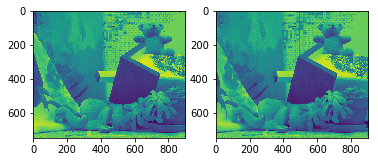

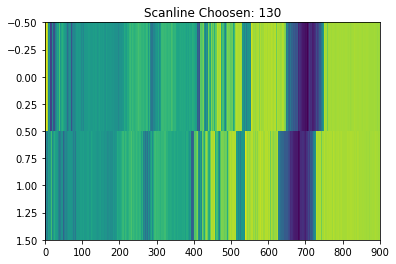

'\na = np.random.rand(3, 3)\na[0] = np.array([84, 150, 60])\na[1] = np.array([92, 13, 162])\na[2] =  np.array([21, 145, 52])\nplt.imshow(a)\n'

In [0]:
#Load image:
from PIL import Image
import matplotlib.pyplot as plt


imgLeft = Image.open('./view3.ppm').convert('L')
imgRight = Image.open('./view5.ppm').convert('L')

a = imgLeft.size
print("original size of the figure: {}".format(a))
reshapeSize = (a[0], a[1])
print("We resize the figure in : {}".format(reshapeSize))

imgLeft = imgLeft.resize(reshapeSize, Image.ANTIALIAS)
imgRight = imgRight.resize(reshapeSize, Image.ANTIALIAS)

numpyLeftImg = np.asarray(imgLeft)
numpyRightImg = np.asarray(imgRight)


#numpyLeftImg = numpyLeftImg[:, 12:112]
#numpyRightImg = numpyRightImg[:, 12:112]



scanlineChoosen = 130


# Let's begin with a size of 100 for test

numpyLeftImg = numpyLeftImg
numpyRightImg = numpyRightImg

plt.figure()
plt.subplot(121)
plt.imshow(numpyLeftImg)
plt.subplot(122)
plt.imshow(numpyRightImg)
plt.show()




a = np.full((2, numpyLeftImg.shape[1]), 0)
a[0, :] = numpyLeftImg[scanlineChoosen, :]
a[1:, :] = numpyRightImg[scanlineChoosen, :]
plt.title("Scanline Choosen: " + str(scanlineChoosen))
plt.imshow(a, interpolation='nearest', aspect='auto')
plt.show()



#plt.imshow(numpyMiddleImg)
#plt.imshow(numpyRightImg)




#a = np.random.rand(2, 5)
#a[0] = np.array([0, 30, 140, 40, 0])
#a[1] = np.array([30, 140, 0, 40, 0])
#plt.imshow(a)



"""
a = np.random.rand(3, 4)
a[0] = np.array([84, 150, 60, 21])
a[1] = np.array([92, 13, 72, 162])
a[2] =  np.array([21, 90, 148, 20])
plt.imshow(a)
"""

#With size 3, it works !
"""
a = np.random.rand(3, 3)
a[0] = np.array([84, 150, 60])
a[1] = np.array([92, 13, 162])
a[2] =  np.array([21, 145, 52])
plt.imshow(a)
"""

In [0]:
# The main 

lenSequence = 900
lenSequence += 1 # To add the gap at the beginning of the sequences.



print("I BEGIN TO LOAD")
cumul_nb_cells_computed = cp.load("./2D_lenSeq_" + str(lenSequence) + "/number_cells_computed.npy")
position_in_nw_flatten_matrix = cp.load("./2D_lenSeq_" + str(lenSequence) + "/position_cells_to_compute.npy")

pos_in_seq1 = cp.full((lenSequence**2, ), -1)
pos_in_seq1 += position_in_nw_flatten_matrix // (lenSequence+1)

pos_in_seq2 = cp.full((lenSequence**2, ), -1)
pos_in_seq2 += position_in_nw_flatten_matrix % (lenSequence+1)


print("FINISH TO LOAD")


seq1 = numpyLeftImg[scanlineChoosen, :]
seq2 = numpyRightImg[scanlineChoosen, :]
#seq1 = a[0]
#seq2 = a[1]

print(seq1.shape)


sequenceNumber1 = seq1
sequenceNumber2 = seq2



u1 = cp.empty((lenSequence, ), dtype=cp.int32)
u1[0] = -256*2-1
u1[1:] = cp.array(seq1)

u2 = cp.empty((lenSequence, ), dtype=cp.int32)
u2[0] = -256*3-1
u2[1:] = cp.array(seq2)

print(u1.shape)
print(u2.shape)

print(u1)
print(u2)


I BEGIN TO LOAD
FINISH TO LOAD
(900,)
(901,)
(901,)
[-513  216  201  194  201  206  215  194  119   94  118   98   79  130
   85   71  111   62   73  122  111  121  112   83   75   62   81  124
  124  114  109  126  138  144  139  130  120  137  151  163  168  143
  131  124  132  145  143  148  150  146  143  140  139  136  139  142
  133  127  124  117  109  102  109  114  117  121  127  123  119  124
  137  111   83  112  114  117  115  120  129  121  119  120  124  127
  131  133  128  132  134  132  133  131  133  133  132  132  131  132
  122  121  133  128  122  106  119  125  128  133  131  132  133  132
  133  135  133  133  136  137  136  133  136  137  136  134  134  133
  132  134  134  131  133  136  138  134  137  140  137  135  138  136
  132  127  130  132  134  138  141  138  136  136  134  134  135  134
  133  133  134  137  136  131  130  131  130  128  131  135  136  133
  131  132  134  131  131  128  131  132  132  129  131  131  128  131
  129  129  135  131  130

In [0]:
    start = time.time()

    print("COMPUTE SCORE MATRIX : ")
    nw_matrix, time_taken_each_step = computeScoringMatrix(u1, u2)#, pos_in_seq1, pos_in_seq2, pos_in_seq3, cumul_nb_cells_computed, position_in_nw_flatten_matrix)
    #print(nw_matrix)

    end = time.time()
    print("\nTime to calculate the Needleman and Wunch matrix : {} seconds".format(end - start))

COMPUTE SCORE MATRIX : 
1801 / 1801
Time to calculate the Needleman and Wunch matrix : 2.32686400414 seconds


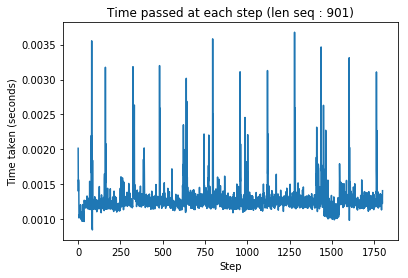

Mean : 0.001290356583065457
Var : 6.005257257998206e-08


In [0]:
plt.plot(list(cp.arange(len(time_taken_each_step))), time_taken_each_step)
plt.title("Time passed at each step (len seq : " + str(lenSequence) + ")")
plt.xlabel("Step")
plt.ylabel("Time taken (seconds)")
plt.show()

arrayTempsPasseAtEachStep = cp.asarray(time_taken_each_step[:])
print("Mean : {}\nVar : {}".format(arrayTempsPasseAtEachStep.mean(), arrayTempsPasseAtEachStep.var()))


DETERMINATE PASS : 
(902, 902)
ALIGN SEQUENCES : 

Time to baktrack the Needleman and Wunch matrix and align the sequences: 0.237998962402 seconds
[216, 201, 194, 201, 206, 215, 194, 119, 94, 118, 98, 79, 130, 85, 71, 111, 62, 73, 122, 111, 121, 112, 83, 75, 62, 81, 124, 124, 114, 109, 126, 138, 144, 139, 130, 120, 137, 151, 163, 168, 143, 131, 124, 132, 145, 143, 148, 150, 146, 143, 140, 139, 136, 139, 142, 133, 127, 124, 117, 109, 102, 109, 114, 117, 121, 127, 123, 119, 124, 137, 111, 83, '-', 112, 114, 117, 115, 120, 129, 121, 119, 120, 124, 127, 131, 133, 128, 132, 134, 132, 133, 131, 133, 133, 132, 132, 131, 132, 122, 121, 133, 128, 122, 106, 119, 125, 128, 133, 131, 132, 133, 132, 133, 135, 133, 133, 136, 137, 136, 133, 136, 137, 136, 134, 134, 133, 132, 134, 134, 131, 133, 136, 138, 134, 137, 140, 137, 135, 138, 136, 132, 127, 130, 132, 134, 138, 141, '-', 138, 136, 136, 134, 134, 135, 134, 133, 133, 134, 137, 136, 131, 130, 131, 130, 128, 131, 135, 136, 133, 131, 132, 134, 131,

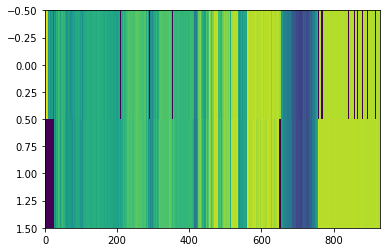

Len seq : 900


In [0]:
  #print(nw_matrix)
  begin = time.time()
  print("DETERMINATE PASS : ")
  print(nw_matrix.shape)
  path = determinatePath(cp.asnumpy(nw_matrix))
  #print(path)

  print("ALIGN SEQUENCES : ")
  S1final, S2final = alignSequences(seq1, seq2, path)
  end = time.time()
  print("\nTime to baktrack the Needleman and Wunch matrix and align the sequences: {} seconds".format(end - begin))
  
  print(S1final)
  print(S2final)
  
   # print the align sequences:
  for i in range(len(S1final)):
    if (S1final[i] == '-'):
      S1final[i] = 0

  for i in range(len(S2final)):
    if (S2final[i] == '-'):
      S2final[i] = 0
      
      
  a = np.full((2, max(len(S1final), len(S2final))), 0)
  a[0, :len(S1final)] = np.array(S1final, dtype=np.int32)
  a[1, :len(S2final)] = S2final
  plt.imshow(a, interpolation='nearest', aspect='auto')
  plt.show()
  print("Len seq : {}".format(len(seq1)))

In [0]:
numberScanLine = reshapeSize[1]
#lenSequence = reshapeSize[0] + 1
lenSequence = 900
lenSequence += 1


print("I BEGIN TO LOAD")
cumul_nb_cells_computed = cp.load("./2D_lenSeq_" + str(lenSequence) + "/number_cells_computed.npy")
position_in_nw_flatten_matrix = cp.load("./2D_lenSeq_" + str(lenSequence) + "/position_cells_to_compute.npy")

pos_in_seq1 = cp.full((lenSequence**2, ), -1)
pos_in_seq1 += position_in_nw_flatten_matrix // (lenSequence+1)

pos_in_seq2 = cp.full((lenSequence**2, ), -1)
pos_in_seq2 += position_in_nw_flatten_matrix % (lenSequence+1)


print("FINISH TO LOAD")




disparityMap = np.empty((numberScanLine, lenSequence-1))

begin_compute = time.time()
for k in range(numberScanLine):
  print("\nScanline : {} / {}".format(k, numberScanLine))
  scanlineChoosen = k
  seq1 = numpyLeftImg[scanlineChoosen, :]
  seq2 = numpyRightImg[scanlineChoosen, :]
  sequenceNumber1 = seq1
  sequenceNumber2 = seq2



  u1 = cp.empty((lenSequence, ), dtype=cp.int32)
  u1[0] = -256*2-1
  u1[1:] = cp.array(seq1)

  u2 = cp.empty((lenSequence, ), dtype=cp.int32)
  u2[0] = -256*3-1
  u2[1:] = cp.array(seq2)

  
  scoreMatrix, tempsPasseAtEachStep = computeScoringMatrix(u1, u2)

  path = determinatePath(cp.asnumpy(scoreMatrix))
  S1final, S2final = alignSequences(seq1, seq2, path)
  
  DisparityMapS1 = []
  DisparityMapS2 = []
  
  """
 # print the align sequences:
  for i in range(len(S1final)):
    if (S1final[i] == '-'):
      S1final[i] = 0
    else:
      DisparityMapS1.append(i)
   # else:
   #   S1final[i] = int(S1final[i] / 2)

  for i in range(len(S2final)):
    if (S2final[i] == '-'):
      S2final[i] = 0
    else:
      DisparityMapS2.append(i)
    #else:
    #  S2final[i] = int(S2final[i] / 2)
  """
  
  
  

  shift1 = 0
  shift2 = 0
  for i in range(len(S1final)):
    if (S1final[i] != '-' and S2final[i] != '-'):
      DisparityMapS1.append(shift1)
      DisparityMapS2.append(shift2)
      shift1 += 1
      shift2 += 1
    elif (S1final[i] != '-' and S2final[i] == '-'):
      shift1 += 1
      DisparityMapS1.append(0)
      DisparityMapS2.append(0)
    else:
      shift2 += 1
      DisparityMapS1.append(0)
      DisparityMapS2.append(0)

  #print("")
  #print(S1final)
  #print(S2final)
  #print(DisparityMapS1)
  #print(DisparityMapS2)
  DisparityMapS1 = np.array(DisparityMapS1)
  DisparityMapS2 = np.array(DisparityMapS2)
  distance2 = np.abs(DisparityMapS1 - DisparityMapS2)
  #print(distance)
  #print("")

  #print(distance.shape)
  #distance = distance.reshape((1, len(distance)))
  distance = np.zeros((1, lenSequence-1))
  #distance[0, 0:len(distance2)] = distance2
  distance = distance2[0: lenSequence-1]
  disparityMap[k] = distance 

end_compute = time.time()
print("Time taken : {} secs".format(end_compute - begin_compute))


I BEGIN TO LOAD
FINISH TO LOAD

Scanline : 0 / 750
1801 / 1801
Scanline : 1 / 750
1801 / 1801
Scanline : 2 / 750
1801 / 1801
Scanline : 3 / 750
1801 / 1801
Scanline : 4 / 750
1801 / 1801
Scanline : 5 / 750
1801 / 1801
Scanline : 6 / 750
1801 / 1801
Scanline : 7 / 750
1801 / 1801
Scanline : 8 / 750
1801 / 1801
Scanline : 9 / 750
1801 / 1801
Scanline : 10 / 750
1801 / 1801
Scanline : 11 / 750
1801 / 1801
Scanline : 12 / 750
1801 / 1801
Scanline : 13 / 750
1801 / 1801
Scanline : 14 / 750
1801 / 1801
Scanline : 15 / 750
1801 / 1801
Scanline : 16 / 750
1801 / 1801
Scanline : 17 / 750
1801 / 1801
Scanline : 18 / 750
1801 / 1801
Scanline : 19 / 750
1801 / 1801
Scanline : 20 / 750
1801 / 1801
Scanline : 21 / 750
1801 / 1801
Scanline : 22 / 750
1801 / 1801
Scanline : 23 / 750
1801 / 1801
Scanline : 24 / 750
1801 / 1801
Scanline : 25 / 750
1801 / 1801
Scanline : 26 / 750
1801 / 1801
Scanline : 27 / 750
1801 / 1801
Scanline : 28 / 750
1801 / 1801
Scanline : 29 / 750
1801 / 1801
Scanline : 30 / 75

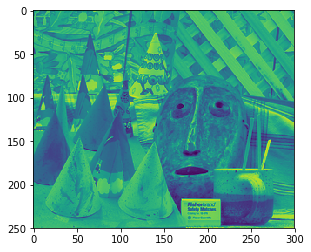

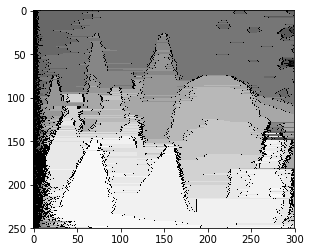

In [0]:
plt.imshow(numpyLeftImg)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

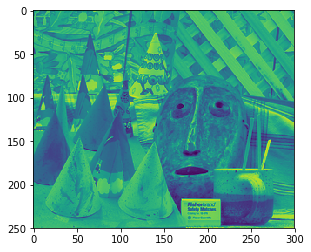

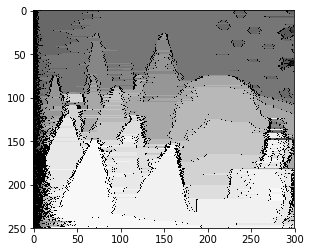

In [0]:
plt.imshow(numpyLeftImg)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

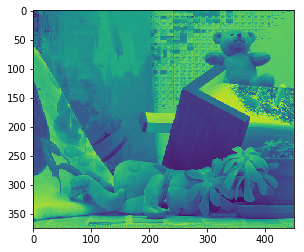

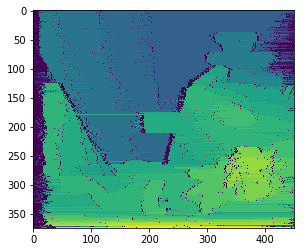

In [0]:
plt.imshow(numpyLeftImg)
plt.show()
plt.imshow(disparityMap)
plt.show()

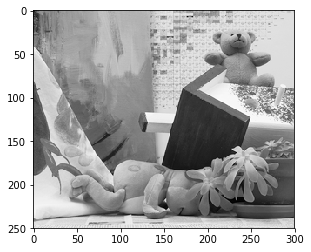

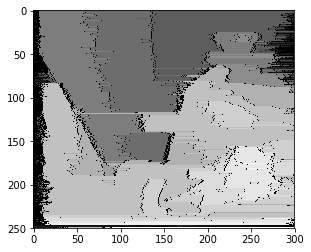

In [0]:
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()

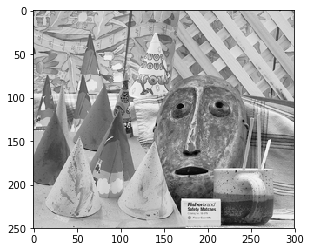

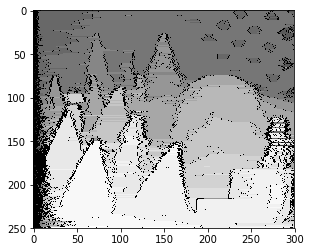

In [0]:
plt.imshow(numpyLeftImg, cmap=matplotlib.cm.Greys_r)
plt.show()
plt.imshow(disparityMap, cmap=matplotlib.cm.Greys_r)
plt.show()